# Avoiding overfitting using regularisation

[Overfitting](regression_overfitting.ipynb) can plague the maximum likelihood approach to model fitting. For example, polynomial fits to the simple 1D regression dataset showed pathalogical behaviour for $D>7$ (see plots below). In this section we will discuss how to mitigate overfitting using regularisation. 

In [10]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

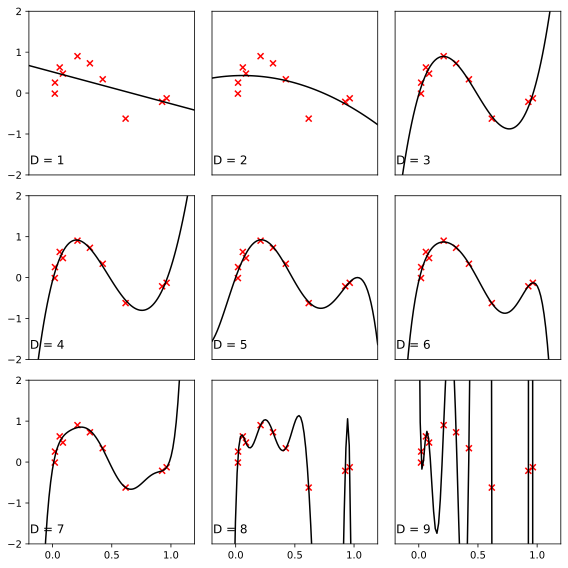

In [11]:
# Load data for nonlinear regression task
x_data = np.load('reg_nonlin_x.npy')
y_data = np.load('reg_nonlin_y.npy')

# 100 points equispaced between 0 and 1
x_plot = np.linspace(-0.2, 1.2, 100)

# Figure to plot models on
fig = plt.figure(figsize = (8, 8))

# Loop over different values of D, fit a different polynomial model for each
for D in range(1, 10):

    # Design matrix corresponding to the input data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_data])
    
    # Solve for maximum-likelihood weights via Moore-Penrose pseudoinverse
    w = np.linalg.solve((phi.T).dot(phi), (phi.T).dot(y_data))
    
    # Design matrix at the prediction points
    phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_plot])
    
    # Mean model predictions
    y_plot = phi_pred.dot(w)
    
    # Plot data and predictions separately for each model
    plt.subplot(3, 3, D)
    
    # Plot data and maximum a posteriori polynomial models
    plt.plot(x_plot, y_plot, color = 'black')
    plt.scatter(x_data, y_data, marker = 'x', color = 'red')
    
    # Format plots
    plt.text(0.1, -1.8, s = 'D = ' + str(D), color = 'black', fontsize = 12,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-2, 2])
    
    if D % 3 is not 1:
        plt.yticks([])
    else:
        plt.yticks(np.linspace(-2, 2, 5))
        
    if D < 7:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 1, 3))
        
plt.tight_layout()
plt.show()

## Overfitted weight estimates

In order to motivate the new approach, let's view effects of overfitting from another perspective by inspecting the estimated weights for each model fit:

In [13]:
# List for storing maximum likelihood weights for each polynomial
weights = []

# Loop over degree of polynomial
for D in range(9):
    
    # Design matrix at training data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_data])
    
    # Solve for the maximum likelihood weights
    w = np.linalg.solve((phi.T).dot(phi), (phi.T).dot(y_data))
    
    # Pad with zeroes for unused weights - this is used for the table below
    w = np.pad(w, (0, 9 - w.shape[0]), 'constant', constant_values = (0, 0))
    weights.append(w)

# Row and column names for table
row_names = [d for d in range(9)]
column_names = ['\(w_{}\)'.format(d) for d in range(9)]

# Create table and show it
table = pandas.DataFrame(weights, row_names, column_names).round(2)
table.columns.name = "D"
table

D,\(w_0\),\(w_1\),\(w_2\),\(w_3\),\(w_4\),\(w_5\),\(w_6\),\(w_7\),\(w_8\)
0,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.52,-0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.43,0.11,-0.92,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.03,9.83,-30.05,20.61,0.00,0.00,0.00,0.00,0.00
4,-0.07,11.05,-36.72,32.37,-6.38,0.00,0.00,0.00,0.00
5,0.00,7.98,-11.57,-43.34,87.70,-40.80,0.00,0.00,0.00
6,-0.08,12.52,-64.96,193.72,-387.43,395.19,-149.15,0.00,0.00
7,-0.16,17.64,-154.12,796.59,-2322.57,3541.54,-2645.98,767.18,0.00
8,-1.25,102.88,-1982.26,17260.67,-77552.28,191604.56,-261551.39,184026.39,-51922.83


The estimated weights contain interesting structure: for low order polynomials, the weights take modest values. However, as the order of the polynomial increases the magnitudes of the high-order weight estimates increase dramatically and the signs oscillate. The large magnitude weights lead to polynomials with extreme gradients and the oscillating signs enable many zero crossings in the region of the observed data. The model is contorting to go through the observed data.

## Regularising least squares

The observation that the well-fit models have estimated weight values whose magnitudes are modest, suggests that overfitting could be mitigated by penalising large weight magnitudes. For example, a simple approach takes the sum-of-square-errors cost and adds a quadratic term $\frac{\alpha}{2}\mathbf{w}^\top\mathbf{w}$,  

\\[C_2^{(\text{reg})} = \big|\big|\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big|\big|^2 +\frac{\alpha}{2}\mathbf{w}^\top\mathbf{w}. \\]

Here $\alpha > 0$ is a constant. Now, if a weight magnitude becomes large, the quadratic term penalises the fit with $\alpha$ controlling the size of the penalty. This method discourages the weights from becoming large and is known as **regularisation**. Again, there is some arbitrariness in our choice of regularisation term $-$ why use $\mathbf{w}^\top\mathbf{w} = ||\mathbf{w}||^2$ and not $||\mathbf{w}||$ or in fact $||\mathbf{w}||^p$ for arbitrary $p$? Regularization using different powers $p$ is known as $Lp$ regularisation. With $L1 \implies ||\mathbf{w}||$ and $~L2 \implies ||\mathbf{w}||^2$.

## Interpretation as maximum a posteriori fitting

Probabilistic approaches to fitting non-linear regression place a prior distribition on the weights, $p(\mathbf{w})$. Expecting functions to typically have rather modest coefficients with small numbers of zero crossings, we place an independent Gaussian prior on the weights $p(\mathbf{w}| \sigma_{\mathbf{w}}^2) = \mathcal{N}(\mathbf{w};\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$. Here the variance $\sigma_{\mathbf{w}}^2$ controls the magnitude of the polynomials we expect to see before observing the data. 

Here are some samples from the resulting model produced by first sampling weights from the prior, $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$,  and then computing the resulting function $f^{(m)}(x)=\boldsymbol{\phi}(x)^\top \mathbf{w}^{(m)}$.

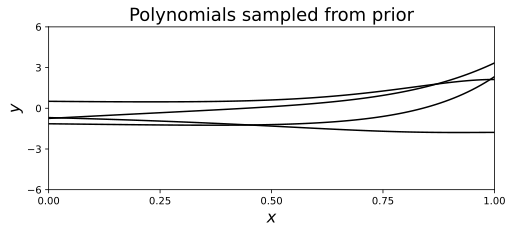

In [14]:
# Order of polynomial
D = 9

# Prior weight variance
var_w = 1

# Number of samples
M = 5

# 100 points equispaced between 0 and 1
x_plot = np.linspace(0, 1, 100) 

# Design matrix at training points
phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_plot]) 

# Figure on which to plot sampled functions
plt.figure(figsize=(8, 3))

# Sample M different models
for m in range(1, M):
    
    # Sample weights from prior
    w = np.random.normal(0, var_w ** 0.5, D + 1)

    # Plot function at input locations
    y_plot = phi_pred.dot(w)

    # Plot sampled model
    plt.plot(x_plot, y_plot, color='k')

# Format plot
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(-6, 6, 5))
plt.xlim([0, 1])
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.title('Polynomials sampled from prior', fontsize=18)
plt.show()

We can now apply probabilistic inference for the weights using Bayes' rule to find the maximum a posteriori setting of the weights given the observed data:

$$\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2)\\
& = \underset{\mathbf{w}}{\mathrm{arg\,min}} \;   (\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w}) - \alpha \mathbf{w}^\top \mathbf{w}  \;\; \text{where} \;\;\alpha = \frac{\sigma_y^2}{\sigma_\mathbf{w}^2}
\end{align}$$

<details class="graydrop">
<summary>Details: Deriving the MAP weights</summary>
<div>

First we apply Bayes' rule

$$\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = \frac{ p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{y}\mid\mathbf{X}, \mathbf{w}, \sigma_y^2) }{p(\mathbf{y}| \sigma_y^2,\sigma_{\mathbf{w}}^2)} \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{y}\mid\mathbf{X}, \mathbf{w}, \sigma_y^2).
\end{align}$$

Next we substitute in for the likelihood and prior,

$$\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) = \frac{1}{(2\pi \sigma_\mathbf{w}^2)}\text{exp}\big(-\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} \big) \times \frac{1}{(2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})\big).
 \end{align}$$

Now pulling the prior and likelihood terms into a single exponential we have,

$$\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = \frac{1}{(2\pi \sigma_\mathbf{w}^2) (2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} -\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})\big)
\end{align}$$

Taking logs and combining terms that do not depend on $\mathbf{w}$ into a constant,

$$\begin{align}
\log p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = -\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} -\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w}) + \text{const.}.
\end{align}$$

Now we see that maximising $p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2)$ is the same as minimising $\frac{\sigma_y^2}{\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} +(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})$.

</div>
</details>
<br>

So, the simple quadratic regularisation can be interpreted as arising from a Gaussian prior on the weights and $\alpha$ is the ratio of the observation noise variance to the prior weight variance. Again the probabilistic approach reveals the hidden assumptions and makes it simple to assess their suitability. 

Let's now optimise the new cost. The use of a quadratic penalty, or equivalently a Gaussian prior on the weights, leads to an analytic solution.

$$\begin{align}\frac{\partial\mathcal{L}}{\partial \mathbf{w}} = - \boldsymbol{\Phi}^\top(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) + \alpha\mathbf{w} = 0\\
~\\
- \boldsymbol{\Phi}^\top\mathbf{y} + \boldsymbol{\Phi}^\top\boldsymbol{\Phi}\mathbf{w} + \alpha \mathbf{I}\mathbf{w} = 0\\
~\\
\implies \boxed{\mathbf{w} = (\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1}\boldsymbol{\Phi}^\top\mathbf{y}}\\
\end{align}$$

Comparing this with the unregularized expression for $\mathbf{w}$:

$$\begin{align}
\mathbf{w} &= (\boldsymbol{\Phi}^\top\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^\top\mathbf{y},~\text{unregularized},\\
~\\
\mathbf{w} &= (\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha \mathbf{I})^{-1}\boldsymbol{\Phi}^\top\mathbf{y},~\text{regularized},\\
\end{align}$$

we see that the only difference is the added $\alpha\mathbf{I}$ term. Since this is inside the $(\cdot)^{-1}$ matrix inverse we can intuitively see that its effect is to reduce the magnitude of the matrix elements of $(\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1}$ and hence those of $\mathbf{w}$. Consider for example the limiting case $\boldsymbol{\Phi}^\top\boldsymbol{\Phi} << \alpha\mathbf{I}$. Then $(\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1} \approx \alpha^{-1}\mathbf{I}$ and increasing $\alpha$ results in smaller $\mathbf{w}$. Note that the value of $\alpha$ is arbitrarily chosen (we will later address this point). 

Let's have a look on how regularization affects the model. We'll assume small observations noise $\sigma_{y} = 0.01$ and a prior weight standard deviation of $\sigma_{\mathbf{w}} = 1$ so that $\alpha = 10^{-4}$:

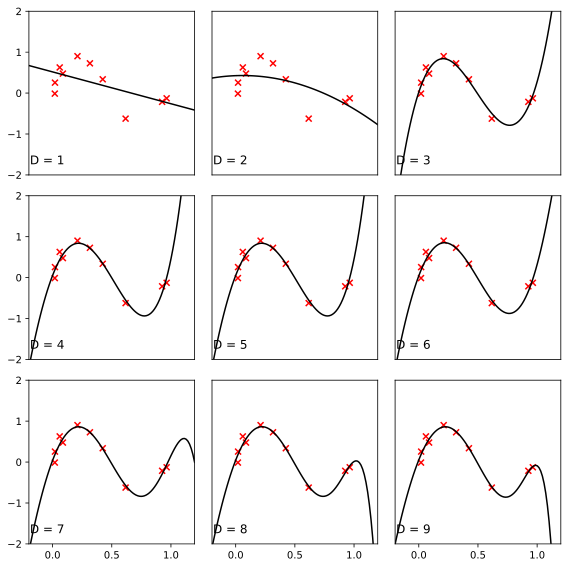

In [15]:
# Regularisation alpha
alpha = 10 ** -4 

# 100 points equispaced between 0 and 1
x_plot = np.linspace(-0.2, 1.2, 100)

# Figure to plot maximum a posteriori models and training data
fig = plt.figure(figsize = (8, 8))

for D in range(1, 10):
    
    # Design matrix at training data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_data])
    
    # regularization term = lambda * (indentity matrix)
    reg_term = alpha * np.eye(D + 1) 
    
    # Solve for the maximum a posteriori weights
    w = np.linalg.solve((phi.T).dot(phi) + reg_term, (phi.T).dot(y_data))
    
    # Design matrix for plotting
    phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_plot])
    
    # model predictions as before
    y_plot = phi_pred.dot(w)
    
    # Plot data and predictions separately for each model
    plt.subplot(3, 3, D)
    
    # Plot data and maximum a posteriori polynomial models
    plt.plot(x_plot, y_plot, color = 'black')
    plt.scatter(x_data, y_data, marker = 'x', color = 'red')
    
    # Format plots
    plt.text(0.1, -1.8, s = 'D = ' + str(D), color = 'black', fontsize = 12,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-2, 2])
    
    if D % 3 is not 1:
        plt.yticks([])
    else:
        plt.yticks(np.linspace(-2, 2, 5))
        
    if D < 7:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 1, 3))
        
plt.tight_layout()
plt.show()

The plots show that overfitting is greatly diminished. This did involve introducing another free-parameter $\alpha$ which has to be set.  **Try altering the value of \\(\boldsymbol{\alpha}\\) to see how the fits change**. One principled way to choose \\(\alpha\\) would be to try different values for it using training/test datasets, and pick the \\(\alpha\\) which results in the best test performance. Let's also have a look at how regularisation affects the train/test errors.

In [16]:
# Load larger dataset for splitting into training and validation sets
x_extended = np.load('reg_nonlin_x_extended.npy')
y_extended = np.load('reg_nonlin_y_extended.npy')

# Split into training and validation sets
x_train = x_extended[:10]
x_valid = x_extended[10:]
y_train = y_extended[:10]
y_valid = y_extended[10:]

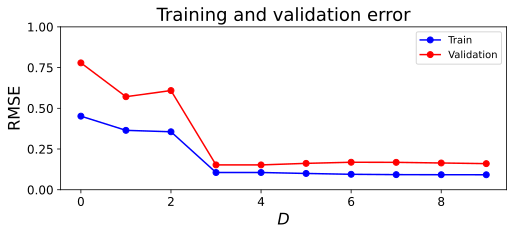

In [17]:
# Regularisation alpha
alpha = 10 ** -5

# Arrays for storing train and validation errors
train_errors = []
valid_errors = []

for D in range(10):
    
    # regularization term = lambda * (indentity matrix)
    reg_term = alpha * np.eye(D + 1)
    
    # Design matrix at training data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_train])
    
    # Solve for the maximum a posteriori weights
    w = np.linalg.solve((phi.T).dot(phi) + reg_term, (phi.T).dot(y_train))
    
    # Mean predictions at the training data
    y_pred_train = phi.dot(w)
    
    # Calculating RMS error of the training data
    train_rmse = np.mean((y_pred_train - y_train) ** 2) ** 0.5
    
    # Compute mean model predictions at the validation data
    phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_valid])
    y_pred = phi_pred.dot(w)
    
    # Calculating RMS error of the validation data
    valid_rmse = np.mean((y_pred - y_valid) ** 2) ** 0.5
    
    train_errors.append(train_rmse)
    valid_errors.append(valid_rmse)
    
# Plot training and validation errors
plt.figure(figsize=(8, 3))
plt.plot(np.arange(0, 10),
         train_errors,
         color='blue',
         marker='o',
         label='Train')

plt.plot(np.arange(0, 10),
         valid_errors,
         color='red',
         marker='o',
         label='Validation')

# Format plots
plt.title('Training and validation error', fontsize=18)
plt.xlabel('$D$', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0, 1, 5), fontsize=12)
plt.gca().legend()
plt.show()

As expected, the training error steadily decreases with $D$. The test error again reaches a minimum for $D = 3$, but unlike in the unregularised case, it doesn't explode for large $D$, because the regularization term prevents the weights from becoming large. To verify this point, let's check the values of the weights:

In [18]:
# Arrays to store the maximuum a posteriori weights
weights = []

# Regularisation alpha
alpha = 10 ** -4 

for D in range(9):
    
    # Design matrix at training data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_data])
    
    # regularization term = lambda * (indentity matrix)
    reg_term = alpha * np.eye(D + 1)
    
    # Solve for the maximum likelihood weights
    w = np.linalg.solve((phi.T).dot(phi) + reg_term, (phi.T).dot(y_data))
    
    # Pad with zeroes for unused weights - this is used for the table below
    w = np.pad(w, (0, 9 - w.shape[0]), 'constant', constant_values = (0, 0))
    weights.append(w)

# Row and column names for table
row_names = [d for d in range(9)]
column_names = ['\(w_{}\)'.format(d) for d in range(9)]

# Create table and show it
table = pandas.DataFrame(weights, row_names, column_names).round(2)
table.columns.name = "D"
table

D,\(w_0\),\(w_1\),\(w_2\),\(w_3\),\(w_4\),\(w_5\),\(w_6\),\(w_7\),\(w_8\)
0,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.52,-0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.43,0.11,-0.92,0.00,0.00,0.00,0.00,0.00,0.00
3,0.02,8.73,-26.86,18.38,0.00,0.00,0.00,0.00,0.00
4,0.05,7.49,-18.78,2.57,9.13,0.00,0.00,0.00,0.00
5,0.05,7.49,-18.78,2.57,9.11,0.01,0.00,0.00,0.00
6,0.04,7.70,-18.95,0.62,9.98,6.50,-5.56,0.00,0.00
7,0.04,7.65,-17.99,-1.47,8.32,8.66,2.44,-7.50,0.00
8,0.04,7.45,-16.79,-2.52,6.31,8.06,5.13,-0.43,-7.24


The weights are significantly decreased by regularization. **You can change $\boldsymbol{\alpha}$ to see how the weights are affected by the size of the regularization term**.

## Summary

Overfitting causes the weight estimates in a linear-in-the-parameters regression model to become extreme. Extreme settings of the weights can be discouraged by penalising their magnitude. This can be interpreted as placing a prior distribution that encodes knowledge before observing the data that the weights are likely to be small in magnitude. In the next section we will look at [bayesian](regression_bayesian.ipynb) approach to regression.

## Questions

<ol>
<li> (a) Look at the plot of the functions sampled from the probabilistic model, \(\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})\) and \(f^{(m)}(x)=\boldsymbol{\phi}(x)^\top \mathbf{w}^{(m)}\) in the case of i) polynomial and ii) Gaussian basis functions. Alter the code to draw a large number of samples. Averaging over samples, qualitatively, how does the mean and variance of the distribution over functions depend on \(x\)? <br> <br> (b) Derive an analytic expression for the mean and the variance of the function, that is \(\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x))\) and \(\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}^2(x)) - \mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x))^2\). Compare what happens to these statistics for the two models in regions far away from the origin. <br> <br> (c) Do these results shed light on when it is appropriate to use i) polynomial basis functions and ii) Gaussian basis functions?
    
<details class='graydrop'>
<summary>Answer</summary>
<div>

The mean of the distribution over functions is defined as:

$$\begin{align}
\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x)) = \int f_{\mathbf{w}}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w}.
\end{align}$$

Substituting in the definition of the function $f_{\mathbf{w}}(x) = \sum_{d=0}^D w_d \phi_d(x)$:

$$\begin{align}
\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x)) = \int \sum_{d=0}^D w_d \phi_d(x) p(\mathbf{w}) \mathrm{d} \mathbf{w} =  \sum_{d=0}^D  \mathbb{E}_{\mathbf{w}} (w_d) \phi_d(x) = 0
\end{align}$$

So the average function is one which takes the value $0$ everywhere. The variance is defined as

$$\begin{align}
\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) = \int f^2_{\mathbf{w}}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w}
\end{align}$$

where we have used the fact that the mean is zero. Substituting in the definition of the function again yields

$$\begin{align}
\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) = \int \sum_{d=0}^D \sum_{d'=0}^D w_d \phi_d(x) w_{d'} \phi_{d'}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w} =  \sum_{d=0}^D \mathbb{E}_{\mathbf{w}}(w^2_d) \phi^2_d(x)
\end{align}$$

where we used the fact that the weights are independent in the prior. Therefore

$$\begin{align}
\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) =  \sigma_{\mathbf{w}}^2 \sum_{d=0}^D \phi^2_d(x).
\end{align}$$

Notice that  in the case of polynomial regression the variance grows with the magnitude of the inputs $|x|$. That is, the functions will typically blow up once the magnitude of $x$ is large enough. For Gaussian basis functions the variance shrinks to zero away from the basis functions. Both behaviours can be problematic for extrapolation. 

</div>
</details></li>
</ol>

<ol start="2"><li> The plot below shows a dataset which has been fit with a linear model using the MAP method. Is the fit satisfactory? How would you modify the model to improve the fit?</li>
</ol>

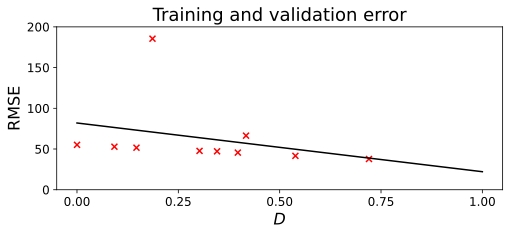

In [9]:
# For this example we sample the data using a different noise model,
# Student's t-distribution. This distribution has heavy tails, meaning
# that it produces outliers more frequently. Modelling heavy-tail data
# with a Gaussian noise model will result in poor fits because the Gaussian
# distribution has ligher tails and is therefore more sensitive to outliners.

# Set random seed
np.random.seed(1)

# Order of polynomial
D = 1 

# Number of data points per model
N = 10 

# Regularisation alpha
alpha = 10 ** -4

# Prior variance of weights
var_w = 1000 

# Observation noise variance
var_y = 0.01


# =============================================================================
# First we sample the data
# =============================================================================

# Input locations of true function / fitted function
x_plot = np.linspace(0, 1, 100)

# Polynomial basis functions
phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_plot]) 
 
# Input locations of data
x_samp = np.random.uniform(0, 1, N) 

# Polynomial basis functions
phi_samp = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp]) 
    
# Sample weights
w = np.random.normal(0, var_w ** 0.5, D+1)

# Plot function at input locations
f_true = phi_pred.dot(w)

# Generate data, corrupted with Student-t heavy tailed noise
y_samp = phi_samp.dot(w) + var_y ** 0.5 * np.random.standard_t(0.5, N)


# =============================================================================
# Next we fit the data
# =============================================================================

# Design matrix at sampled data locations
phi = np.array([[x ** d for d in range(D + 1)] for x in x_samp])

# regularization term = alpha * (indentity matrix)
reg_term = alpha * np.eye(D + 1)

# Solve for maximum a posteriori weights
w = np.linalg.solve((phi.T).dot(phi) + reg_term, (phi.T).dot(y_samp))
y_plot = phi_pred.dot(w)
   
# Figure on whicht to plot data and linear model
plt.figure(figsize=(8, 3))

# Plot sampled data
plt.scatter(x_samp,
            y_samp,
            marker='x',
            color='red')

# Plot fitted linear fit
plt.plot(x_plot, y_plot, color='k')

# Format plots
plt.title('Training and validation error', fontsize=18)
plt.xlabel('$D$', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xticks(np.linspace(0, 1, 5), fontsize=12)
plt.yticks(np.linspace(0, 200, 5), fontsize=12)
plt.show()

<details class='graydrop'>
<summary>Answer</summary>
<div>
The dataset contains an outlier which is causing the best fit line to deviate from the bulk of the data. This will likely lead to bad predictions on test data.
    
The assumption of Gaussian noise (or squared error cost) means that outliers will have significant effect. 

Instead, an alternative observation noise model should be used e.g. a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)
    
$$\begin{align}
p(w_d | \sigma_{w}) = \frac{1}{2 \sigma_{w}}\exp(-|w_d|/\sigma_{w}),
\end{align}$$
    
which results in a cost on the absolute value when using MAP or maximum-likelihood fitting, or a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution)
    
$$\begin{align}
p(w_d | \sigma_{w}) \propto (1 + \frac{v}{v-2} |w_d|^2/\sigma^2_{w})^{- (v+1)/2},
\end{align}$$
    
which was in fact used to generate the data above.

These alternative observation noise models do not result in analytic fits when using maximum likelihood or MAP estimation. However optimisation based approaches can be used. This price is often worth paying as real datasets typically contain outliers and non-Gaussian noise models can make the predictions substantially more robust.

</div>
</details>
<br>